In [1]:
import sys ; sys.path.insert(0, '../')
from notebook_tools import *
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
figures_path="/Users/erezcohen/Desktop/Projects/2NSRC/alaHallAppSRCAnalysisNote/Figures/mean_z_linear_in_pmiss/"

In [3]:
PmissBins = [[0.3,0.45]  , [0.45,0.55] , [0.55,0.65]  , [0.65,0.75] , [0.75,1.0]]

In [4]:
targets = ['C12','Al27','Fe56','Pb208']
target_names = ['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb']
colors = ['blue','red','orange','teal']

# data

In [5]:
columns = ['Pmiss3Mag','pcmX','pcmY','pcmZ','rooWeight'] # ,'Mott','DipoleFF2'
data_allPmiss_noPrecFid = dict()
fana = dict()
for A,target in zip([12,27,56,208],targets):
    rootfname=path+"/OrAnalysisTrees/AdjustedTrees/SRC_e2p_adjusted_%s_PrecFiducials.root"%target
    data_allPmiss_noPrecFid[target] = read_root( rootfname, columns=columns )
    fana[target] = TAnalysisEG2( A, rootfname , ROOT.TString('anaTree') )

In [6]:
# plot p(c.m.) in p(miss) direction as a fucntion of the p(miss)

In [7]:
def linear_06(x, slope, intercept):
    return slope * ( x - 0.6 ) + intercept

def linear_03(x, slope):
    return slope * ( x - 0.3 ) 

def fit_as_a_function_of_pmiss( x , y , yerr , fittype='vanish at 0.3'):
    if fittype=='vanish at 0.3':
        f = linear_03
        p, v = curve_fit(f, xdata=x, ydata=y,sigma=yerr)# fit data using SciPy's Levenberg-Marquart method            
        return p , sqrt(v)
    elif fittype=='centered around 0.6':
        f = linear_06
        p, v = curve_fit(f, xdata=x, ydata=y,sigma=yerr)# fit data using SciPy's Levenberg-Marquart method            
        return p[0] , sqrt(v[0][0]) , p[1] , sqrt(v[1][1]) 

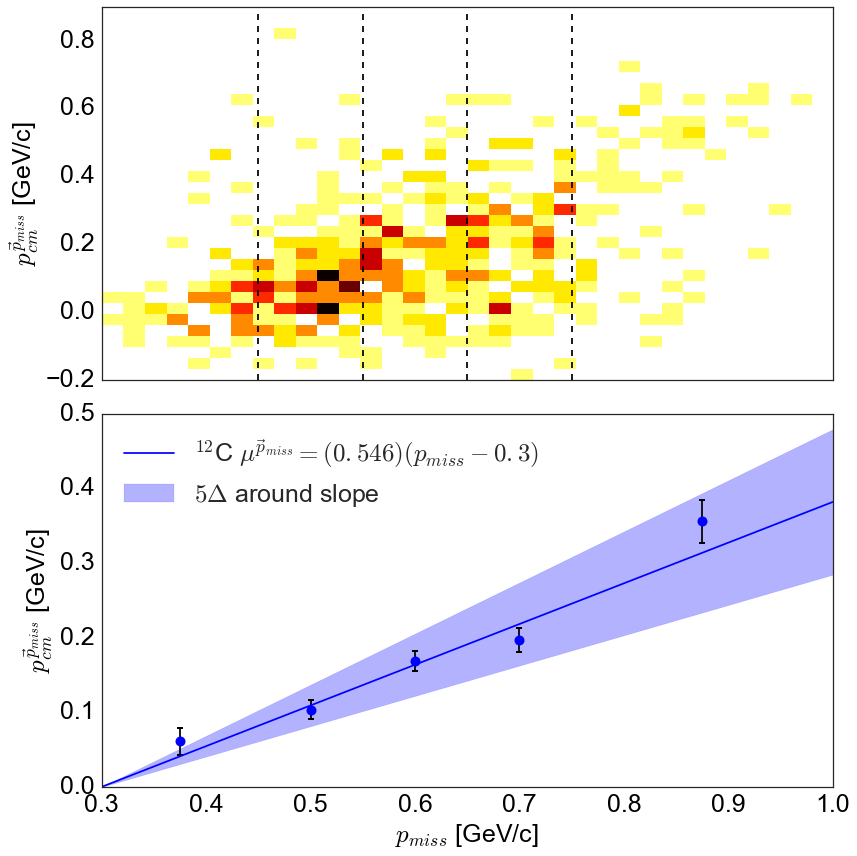

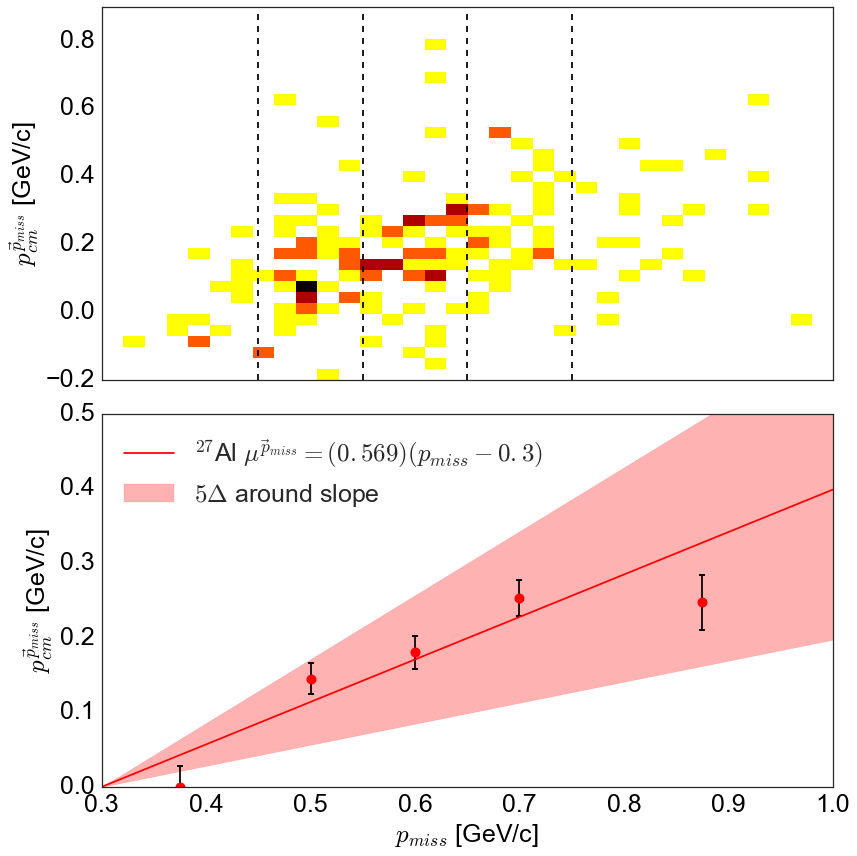

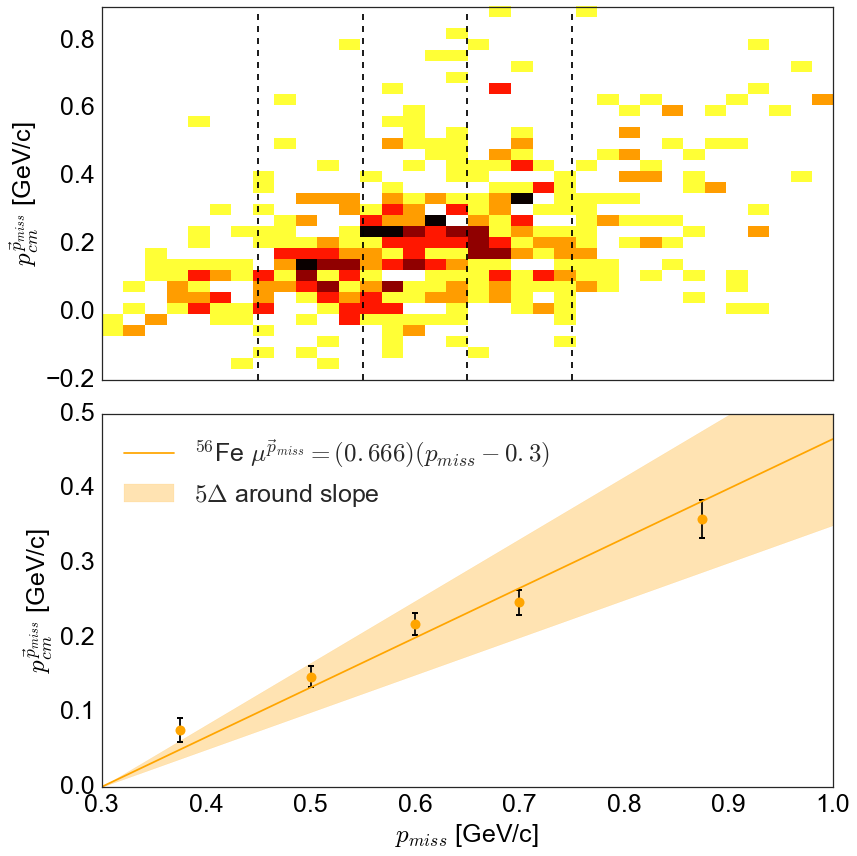

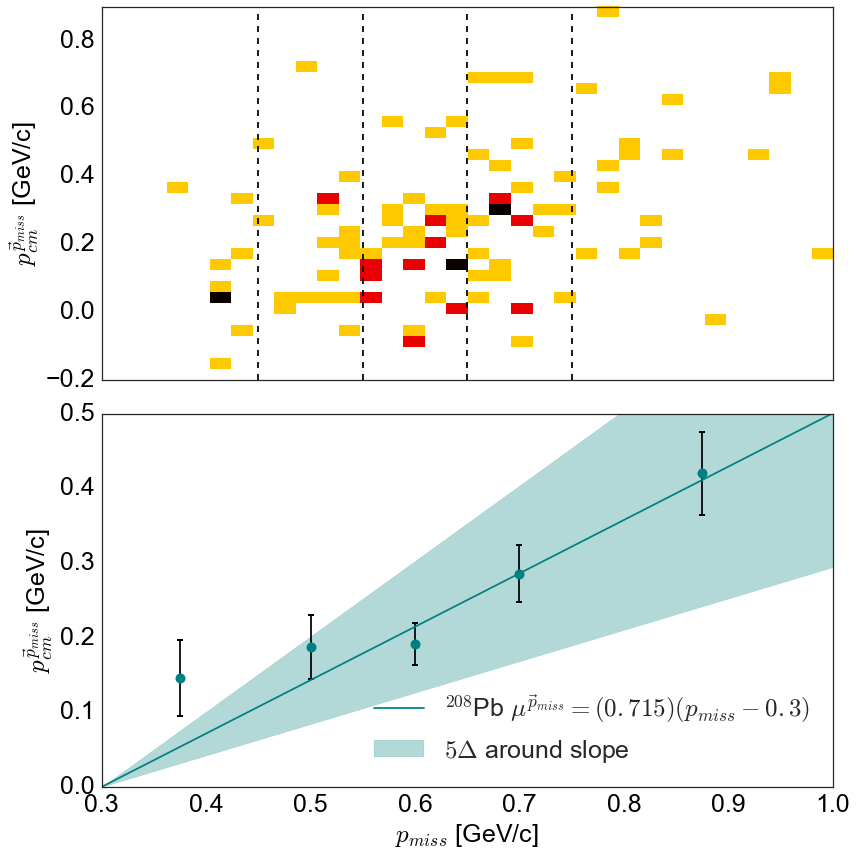

In [8]:
fittype='vanish at 0.3'
p_miss , pcm_z_mean , pcm_z_mean_err = dict() , dict() , dict()
for target,target_name,color in zip(targets,target_names,colors):

    data = data_allPmiss_noPrecFid[target]
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(2,1,1)
    plot_2d_hist( data['Pmiss3Mag'], data['pcmZ']
                 ,bins=(np.linspace(0.3,1.,35),np.linspace(-0.2,0.9,35)),ax=ax);
    set_axes(ax,x_label='',y_label='$p_{cm}^{\\vec{p}_{miss}}$ [GeV/c]',xticks=[0.4,0.5,0.6,0.7,0.8,0.9])
    ax.xaxis.set_major_formatter( NullFormatter() )
    p_miss_target , pcm_z_mean_target , pcm_z_mean_err_target = [] , [] , []
    for bin in range(len(PmissBins)):
        Pm_min,Pm_max = PmissBins[bin][0],PmissBins[bin][1]
        ax.plot([Pm_min,Pm_min],ax.get_ylim(),'--',color='black')
        reduced_data = data[(Pm_min<data['Pmiss3Mag'])&(data['Pmiss3Mag']<Pm_max)]
        p_miss_target.append(0.5*(Pm_min+Pm_max))

        # roofit
        results = fana[target].RooFitCM_1bin( Pm_min , Pm_max , False , False , 10)
        #print 'len(reduced_data):',len(reduced_data),',mean:',results.at(8),'+/-',results.at(9)
        pcm_z_mean_target.append(results.at(8))
        pcm_z_mean_err_target.append(results.at(9))
    ax.set_xlim(0.3,1);ax.set_ylim(-0.2,0.9)

    p_miss[target]=p_miss_target 
    pcm_z_mean[target]=pcm_z_mean_target
    pcm_z_mean_err[target] = pcm_z_mean_err_target
    
    ax = fig.add_subplot(2,1,2)
    ax.errorbar( p_miss[target]  , pcm_z_mean[target] , yerr=pcm_z_mean_err[target] , xerr=0, fmt='o', markersize=10, color=color , ecolor='black', capthick=2)
    x = np.linspace(0.3,1,100)
    fit_results = fit_as_a_function_of_pmiss( x=p_miss[target] , y=pcm_z_mean[target],  yerr=pcm_z_mean_err[target] , fittype=fittype)
    if fittype=='centered around 0.6':
        a1 , a1err , a2 , a2err  = fit_results
        ax.plot( x , a1*(x-0.6) + a2 , color = color ,label="$\\mu^{\\vec{p}_{miss}}=(%.3f)(p_{miss}-0.6)+(%.3f)$"%( a1 , a2 ) )
        ax.fill_between( x , (a1-a1err)*(x-0.6) + a2 , (a1+a1err)*(x-0.6) + a2 , color = color , alpha=0.9)
    elif fittype=='vanish at 0.3':
        slope , slope_err  = fit_results
        ax.plot( x , slope*(x-0.3) , color = color ,label=target_name+" $\\mu^{\\vec{p}_{miss}}=(%.3f)(p_{miss}-0.3)$"%( slope ) )
        ax.fill_between( x , (slope-5*slope_err)*(x-0.3) , (slope+5*slope_err)*(x-0.3) , color = color , alpha=0.3 ,label='$5\\Delta$ around slope')


    ax.legend(fontsize=25,loc='best')

    set_axes(ax,x_label='$p_{miss}$ [GeV/c]',y_label='$p_{cm}^{\\vec{p}_{miss}}$ [GeV/c]')
    ax.set_xlim(0.3,1);ax.set_ylim(0.,0.5);

    plt.tight_layout()
    plt.savefig(figures_path+'PcmZ_vs_Pmiss_'+target+'.pdf')

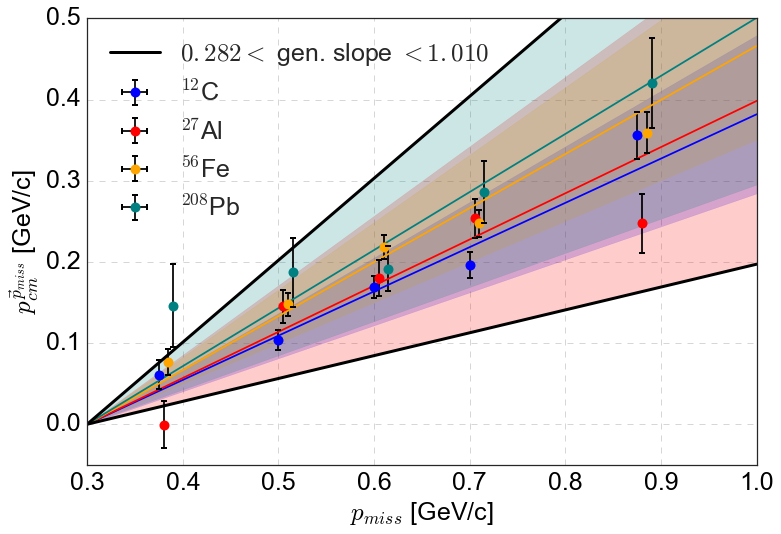

In [9]:
fig,ax = plt.subplots(figsize=(12,8))
fittype='vanish at 0.3'

maximal_slope_band = 0 
minimal_slope_band = 10

for i,(target,target_name,color) in enumerate(zip(targets,target_names,colors)):
    x = np.linspace(0.3,1,100)
    fit_results = fit_as_a_function_of_pmiss( x=p_miss[target] , y=pcm_z_mean[target],  yerr=pcm_z_mean_err[target] , fittype=fittype)
    slope , slope_err  = fit_results
    ax.plot( x , slope*(x-0.3) , color = color )
    ax.fill_between( x , (slope-5*slope_err)*(x-0.3) , (slope+5*slope_err)*(x-0.3) , color=color , alpha=0.2 )
    if (slope-5*slope_err < minimal_slope_band):
        minimal_slope_band = slope-5*slope_err 
    if (slope+5*slope_err > maximal_slope_band):
        maximal_slope_band = slope+5*slope_err 

    
for i,(target,target_name,color) in enumerate(zip(targets,target_names,colors)):
    ax.errorbar( p_miss[target]+i*0.005*np.ones(len(p_miss[target]))  , pcm_z_mean[target] , yerr=pcm_z_mean_err[target] , label=target_name
                , xerr=0, fmt='o', markersize=10, color=color , ecolor='black', capthick=2)
ax.plot( x , minimal_slope_band*(x-0.3) , color = 'black' , linewidth=3 , label='$%.3f<$ gen. slope $<%.3f$'%(minimal_slope_band,maximal_slope_band))
ax.plot( x , maximal_slope_band*(x-0.3) , color = 'black' , linewidth=3 )



set_axes(ax,x_label='$p_{miss}$ [GeV/c]',y_label='$p_{cm}^{\\vec{p}_{miss}}$ [GeV/c]',do_add_grid=True)
ax.set_xlim(0.3,1);ax.set_ylim(-0.05,0.5);
ax.legend(fontsize=25,loc='best')    
plt.savefig(figures_path+'generation_slope_limits.pdf')

# compare with other band types 

In [14]:
cm_parameters = dict()
cm_parameters_with_correction = dict()
for Fiducials in ["PrecFiducials"]:
    cm_pars = pd.read_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/300Pmiss600/alltargets_'+Fiducials+'_dataCMparameters.csv')
    cm_pars['sigma_t'] = 0.5*(cm_pars['sigma_x_unweighted']+cm_pars['sigma_y_unweighted'])
    cm_pars['sigma_tErr'] = 0.5*np.sqrt( np.square(cm_pars['sigma_xErr_unweighted']) + np.square(cm_pars['sigma_yErr_unweighted']) )
    cm_parameters[Fiducials] = cm_pars
    cm_parameters_with_correction[Fiducials] = cm_pars
cm_pars = cm_parameters['PrecFiducials']    

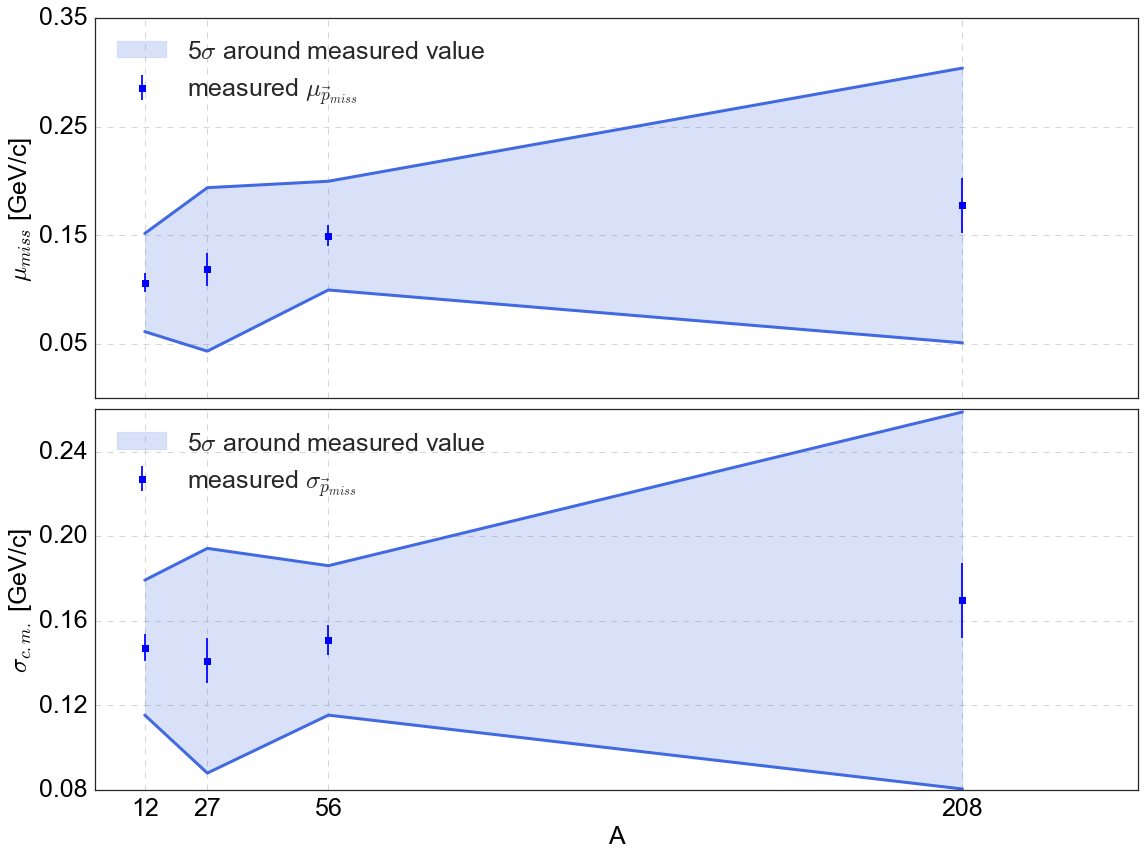

In [15]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(2,1,1)
ax.errorbar(x=cm_pars['A'],y=cm_pars['mean_z_unweighted'],yerr=cm_pars['mean_zErr_unweighted'],fmt='s'
            ,color='blue',label='measured $\\mu_{\\vec{p}_{miss}}$')
ax.fill_between(cm_pars['A']
                ,cm_pars['mean_z_unweighted']-5*cm_pars['mean_zErr_unweighted']
                ,cm_pars['mean_z_unweighted']+5*cm_pars['mean_zErr_unweighted']
                ,color='royalblue',alpha=0.2,label='5$\\sigma$ around measured value')
plt.plot(cm_pars['A'],cm_pars['mean_z_unweighted']-5*cm_pars['mean_zErr_unweighted'],'-',linewidth=3,color='royalblue')
plt.plot(cm_pars['A'],cm_pars['mean_z_unweighted']+5*cm_pars['mean_zErr_unweighted'],'-',linewidth=3,color='royalblue')

set_axes(ax,'','$\\mu_{miss}$ [GeV/c]')
ax.xaxis.set_ticks([12,27,56,208]);ax.yaxis.set_ticks([0.05,0.15,0.25,0.35]);
ax.grid(linestyle='--',alpha=0.8)
ax.legend(fontsize=25,loc='upper left')
ax.xaxis.set_major_formatter(NullFormatter())


ax = fig.add_subplot(2,1,2)
ax.errorbar(x=cm_pars['A'],y=cm_pars['sigma_z_unweighted'],yerr=cm_pars['sigma_zErr_unweighted'],fmt='s'
            ,color='blue',label='measured $\\sigma_{\\vec{p}_{miss}}$')
ax.fill_between(cm_pars['A']
                ,cm_pars['sigma_z_unweighted']-5*cm_pars['sigma_zErr_unweighted']
                ,cm_pars['sigma_z_unweighted']+5*cm_pars['sigma_zErr_unweighted']
                ,color='royalblue',alpha=0.2,label='5$\\sigma$ around measured value')
plt.plot(cm_pars['A'],cm_pars['sigma_z_unweighted']-5*cm_pars['sigma_zErr_unweighted'],'-',linewidth=3,color='royalblue')
plt.plot(cm_pars['A'],cm_pars['sigma_z_unweighted']+5*cm_pars['sigma_zErr_unweighted'],'-',linewidth=3,color='royalblue')

set_axes(ax,'A','$\\sigma_{c.m.}$ [GeV/c]')
ax.xaxis.set_ticks([12,27,56,208]);ax.yaxis.set_ticks([0.08,0.12,0.16,0.20,0.24]);
ax.grid(linestyle='--',alpha=0.8)
ax.legend(fontsize=25,loc='upper left')

plt.tight_layout()

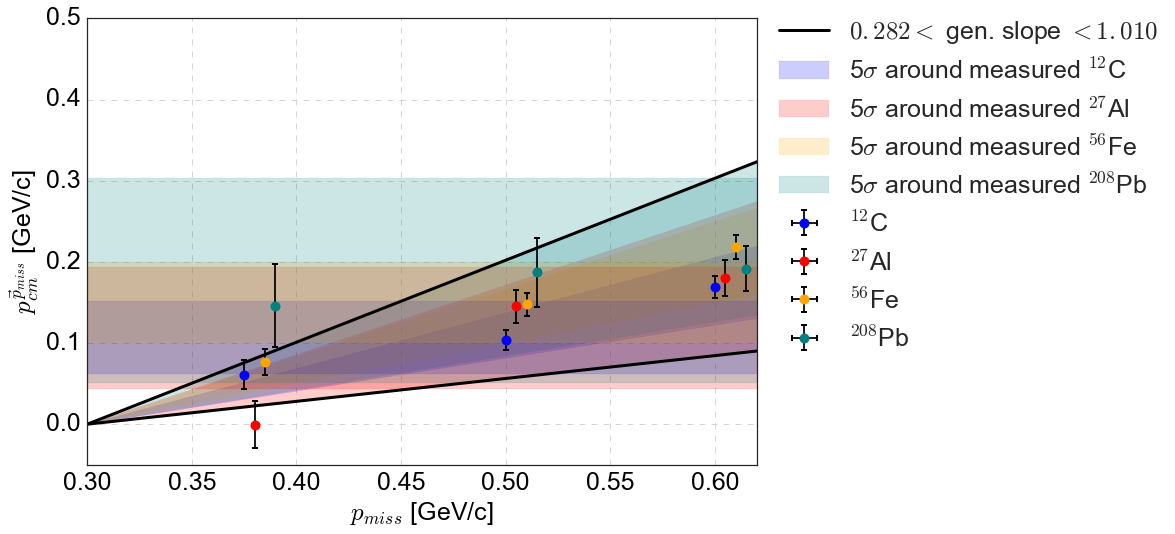

In [26]:
fig,ax = plt.subplots(figsize=(12,8))
fittype='vanish at 0.3'

maximal_slope_band = 0 
minimal_slope_band = 10

for i,(target,target_name,color) in enumerate(zip(targets,target_names,colors)):
    x = np.linspace(0.3,1,100)
    fit_results = fit_as_a_function_of_pmiss( x=p_miss[target] , y=pcm_z_mean[target],  yerr=pcm_z_mean_err[target] , fittype=fittype)
    slope , slope_err  = fit_results
#     ax.plot( x , slope*(x-0.3) , color = color )
    ax.fill_between( x , (slope-5*slope_err)*(x-0.3) , (slope+5*slope_err)*(x-0.3) , color=color , alpha=0.2 )
    if (slope-5*slope_err < minimal_slope_band):
        minimal_slope_band = slope-5*slope_err 
    if (slope+5*slope_err > maximal_slope_band):
        maximal_slope_band = slope+5*slope_err 

    
for i,(target,target_name,color) in enumerate(zip(targets,target_names,colors)):
    ax.errorbar( p_miss[target]+i*0.005*np.ones(len(p_miss[target]))  , pcm_z_mean[target] , yerr=pcm_z_mean_err[target] , label=target_name
                , xerr=0, fmt='o', markersize=10, color=color , ecolor='black', capthick=2)
ax.plot( x , minimal_slope_band*(x-0.3) , color = 'black' , linewidth=3 , label='$%.3f<$ gen. slope $<%.3f$'%(minimal_slope_band,maximal_slope_band))
ax.plot( x , maximal_slope_band*(x-0.3) , color = 'black' , linewidth=3 )

x = np.linspace(0.3,np.max(ax.get_xlim()),100)
                
for A,color,target_name in zip([12,27,56,208],colors,target_names):
    mean_z = float(cm_pars[cm_pars['A']==A]['mean_z_unweighted'])
    mean_z_arr = mean_z*np.ones(len(x))
    mean_z_Err = float(cm_pars[cm_pars['A']==A]['mean_zErr_unweighted'])
    mean_z_Err_arr = mean_z_Err*np.ones(len(x))

#     ax.errorbar(x=x,y=mean_z_arr,yerr=mean_z_Err_arr,fmt='s',color='blue',label='measured $\\mu_{\\vec{p}_{miss}}$')
    ax.fill_between(x
                ,mean_z_arr-5*mean_z_Err_arr
                ,mean_z_arr+5*mean_z_Err_arr
                ,color=color,alpha=0.2,label='5$\\sigma$ around measured '+target_name)
#     plt.plot(x,mean_z_arr-5*mean_z_Err_arr,'-',linewidth=3,color=color)
#     plt.plot(x,mean_z_arr+5*mean_z_Err_arr,'-',linewidth=3,color=color)




set_axes(ax,x_label='$p_{miss}$ [GeV/c]',y_label='$p_{cm}^{\\vec{p}_{miss}}$ [GeV/c]',do_add_grid=True)
ax.set_xlim(0.3,0.62);ax.set_ylim(-0.05,0.5);
leg=ax.legend(bbox_to_anchor=(1.,1.05),fontsize=25,loc=2)
plt.savefig(figures_path+'generation_slope_limits_comparison.pdf',bbox_extra_artists=(leg,), bbox_inches='tight')